In [1]:
import numpy as np
import pyomo.environ as pyo
from pyomo.environ import ConcreteModel, Var, ConstraintList, Objective, SolverFactory, value, RangeSet

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle
import matplotlib.pyplot as plt
import pandas as pd

collocation2_path = os.path.abspath(os.path.join('..', 'utils'))

# Add the directory to sys.path
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from interpolation import BarycentricInterpolation
from data_generation import generate_ode_data
from non_parametric_collocation import collocate_data
from optimization_pyomo import ODEOptimizationModel as ODEOptimizationModel
from pickle_func import pickle_data, unpickle_data

# -------------- regular neural nets --------------
from neural_net import create_train_state, train, neural_ode

In [2]:
import importlib
import optimization_pyomo
import data_generation

importlib.reload(optimization_pyomo)
ODEOptimizationModel = optimization_pyomo.ODEOptimizationModel

In [3]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

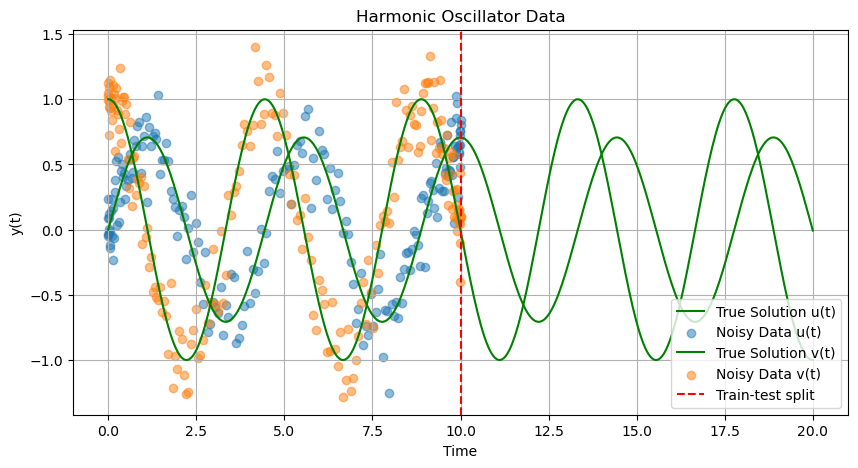

In [8]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t_test, y_test.T[0], 'g-', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t_test, y_test.T[1], 'g-', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Harmonic Oscillator Data')
plt.axvline(x=10, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [146]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

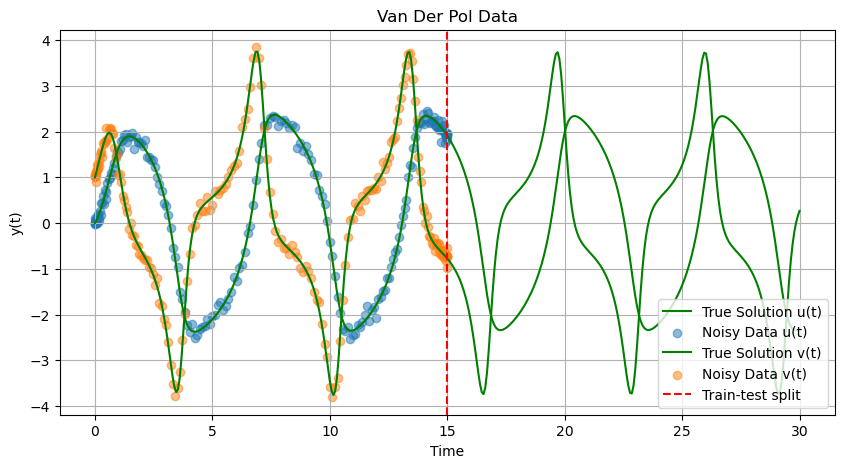

In [147]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t_test, y_test.T[0], 'g-', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t_test, y_test.T[1], 'g-', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Van Der Pol Data')
plt.axvline(x=15, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [148]:
class ODEOptimizationModel:
    def __init__(self, y_observed, t, first_derivative_matrix, layer_sizes, extra_input = None, penalty_lambda=100, max_iter=500, act_func="tanh", w_init_method="random", y_init = None):
        self.y_observed = y_observed
        self.t = t
        self.first_derivative_matrix = first_derivative_matrix
        self.penalty_lambda = penalty_lambda
        self.max_iter = max_iter
        self.act_func = act_func
        self.w_init_method = w_init_method
        self.layer_sizes = layer_sizes
        self.model = ConcreteModel()
        self.y_init = y_init
        self.w_init_method = w_init_method
        self.extra_input = extra_input # only 1D input is supported for now

    def initialize_weights(self, shape):
        if self.w_init_method == 'random':
            return np.random.randn(*shape) * 0.1
        elif self.w_init_method == 'xavier':
            return np.random.randn(*shape) * np.sqrt(2 / (shape[0] + shape[1]))
        elif self.w_init_method == 'he':
            return np.random.randn(*shape) * np.sqrt(2 / shape[0])
        else:
            raise ValueError("Unsupported initialization method. Use 'random', 'xavier', or 'he'.")

    def initialize_biases(self, size):
        return np.random.randn(size) * 0.1

    def build_model(self):
        N = len(self.t)
        model = self.model
        model.t_idx = RangeSet(0, N - 1)

        lower_bound = -10.0
        upper_bound = 10.0
        
        if self.y_init == None:
            model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1, bounds=(lower_bound, upper_bound))
            model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=0.1, bounds=(lower_bound, upper_bound))
        else:
            model.u = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=np.array(self.y_init[0]), bounds=(lower_bound, upper_bound))
            model.v = pyo.Var(model.t_idx, domain=pyo.Reals, initialize=np.array(self.y_init[1]), bounds=(lower_bound, upper_bound))

        if len(self.layer_sizes) == 3:
            input_size = self.layer_sizes[0]
            hidden_size = self.layer_sizes[1]
            output_size = self.layer_sizes[2]

            weight_bounds = (-100.0, 100.0)

            model.W1 = pyo.Var(range(hidden_size), range(input_size), initialize=lambda m, i, j: self.initialize_weights((hidden_size, input_size))[i, j], bounds=weight_bounds)
            model.b1 = pyo.Var(range(hidden_size), initialize=lambda m, i: self.initialize_biases(hidden_size)[i], bounds=weight_bounds)
            model.W2 = pyo.Var(range(output_size), range(hidden_size), initialize=lambda m, i, j: self.initialize_weights((output_size, hidden_size))[i, j], bounds=weight_bounds)
            model.b2 = pyo.Var(range(output_size), initialize=lambda m, i: self.initialize_biases(output_size)[i], bounds=weight_bounds)
            
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            """model.gamma1 = pyo.Var(range(hidden_size), initialize=1.0)
            model.beta1 = pyo.Var(range(hidden_size), initialize=0.0)
            model.gamma2 = pyo.Var(range(output_size), initialize=1.0)
            model.beta2 = pyo.Var(range(output_size), initialize=0.0)"""
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            
        # >>>>>>>>>>>>>>>>>>>>> CONSTRAINTS METHOD 0 <<<<<<<<<<<<<<<<<<<< #
        penalty_terms = []
        model.ode = ConstraintList()
        for i in range(1, N):
            du_dt = sum(self.first_derivative_matrix[i, j] * model.u[j] for j in range(N))
            dv_dt = sum(self.first_derivative_matrix[i, j] * model.v[j] for j in range(N))
            
            
            nn_input = [model.u[i], model.v[i]]
            
            if self.extra_input is not None:
                nn_input.append(self.extra_input[i])
                
            nn_u, nn_v = self.nn_output(nn_input, model)

            collocation_constraint_u = nn_u - du_dt
            collocation_constraint_v = nn_v - dv_dt

            model.ode.add(collocation_constraint_u == 0)
            model.ode.add(collocation_constraint_v == 0)
            
            penalty_terms.append((nn_u)**2 + (nn_v)**2)
            
        def _objective(m):
            data_fit = sum((m.u[i] - self.y_observed[i, 0])**2 + (m.v[i] - self.y_observed[i, 1])**2 for i in m.t_idx)
            smoothing_u = sum((m.u[i+1] - m.u[i])**2 for i in range(len(m.t_idx)-1))
            smoothing_v = sum((m.v[i+1] - m.v[i])**2 for i in range(len(m.t_idx)-1))
            smoothing_term = (smoothing_u + smoothing_v)
            
            reg = sum(m.W1[j, k]**2 for j in range(self.layer_sizes[1]) for k in range(self.layer_sizes[0])) + \
            sum(m.W2[j, k]**2 for j in range(self.layer_sizes[2]) for k in range(self.layer_sizes[1])) + \
            sum(m.b1[j]**2 for j in range(self.layer_sizes[1])) + \
            sum(m.b2[j]**2 for j in range(self.layer_sizes[2]))
            
            return data_fit + reg*0.1

        model.obj = Objective(rule=_objective, sense=pyo.minimize)
        self.model = model 
            
    def nn_output(self, nn_input, m):

        if len(self.layer_sizes) == 3:
            hidden = [sum(m.W1[j, k] * nn_input[k] for k in range(self.layer_sizes[0])) + m.b1[j] for j in range(self.layer_sizes[1])]
            
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            """mean_hidden = sum(hidden) / len(hidden)
            var_hidden = sum((h - mean_hidden)**2 for h in hidden) / len(hidden)
            hidden_norm = [(h - mean_hidden) / pyo.sqrt(var_hidden + 1e-5) for h in hidden]
            hidden_bn = [m.gamma1[j] * hidden_norm[j] + m.beta1[j] for j in range(len(hidden_norm))]"""
            # >>>>>>>>>>>>>>>>>>>>> BATCH NORMALIZATION <<<<<<<<<<<<<<<<<<<< #
            
            if self.act_func == "tanh":
                hidden = [pyo.tanh(h) for h in hidden]
            elif self.act_func == "sigmoid":
                hidden = [1 / (1 + pyo.exp(-h)) for h in hidden]
            elif self.act_func == "softplus":
                hidden = [pyo.log(1 + pyo.exp(h)) for h in hidden]
            outputs = [sum(m.W2[j, k] * hidden[k] for k in range(self.layer_sizes[1])) + m.b2[j] for j in range(self.layer_sizes[2])]
            return outputs  # Ensure outputs are returned

    def solve_model(self):
        solver = pyo.SolverFactory('ipopt')
        
        if self.max_iter:
            solver.options['max_iter'] = self.max_iter
            
        solver.options['print_level'] = 5
        solver.options['tol'] = 1e-8 # Set tolerance if needed
        # solver.options['constr_viol_tol'] = 1e-5
        # solver.options['bound_relax_factor'] = 1e-6  # Default is 1e-8
        # solver.options['compl_inf_tol'] = 1e-2
        # solver.options['dual_inf_tol'] = 10000
        # solver.options['nlp_scaling_method'] = 'gradient-based'  # Or 'user-scaling'
        # solver.options['mu_strategy'] = 'adaptive' # 'monotone'
        # solver.options['check_derivatives_for_naninf'] = 'yes'
        solver.options['halt_on_ampl_error'] = 'yes'
        # solver.options['linear_solver'] = 'mumps'  # Or try 'ma27', 'ma57', 'ma86' if available #DEFAULT 'mumps'
        
        result = solver.solve(self.model, tee=True)
        
        # ------------------- Extract solver information -------------------
        solver_time = result.solver.time
        termination_condition = result.solver.termination_condition
        message = result.solver.message
        
        # ----------------- Extracted information in a dictionary ----------
        solver_info = {
            'solver_time': solver_time,
            'termination_condition': termination_condition,
            'message': message
        }
        
        return solver_info

    def extract_solution(self):
        u = np.array([pyo.value(self.model.u[i]) for i in self.model.t_idx])
        v = np.array([pyo.value(self.model.v[i]) for i in self.model.t_idx])
        return u, v

    def extract_weights(self):
        weights = {}
        if len(self.layer_sizes) == 3:
            W1 = np.array([[pyo.value(self.model.W1[j, k]) for k in range(self.layer_sizes[0])] for j in range(self.layer_sizes[1])])
            b1 = np.array([pyo.value(self.model.b1[j]) for j in range(self.layer_sizes[1])])
            W2 = np.array([[pyo.value(self.model.W2[j, k]) for k in range(self.layer_sizes[1])] for j in range(self.layer_sizes[2])])
            b2 = np.array([pyo.value(self.model.b2[j]) for j in range(self.layer_sizes[2])])
            weights['W1'], weights['b1'], weights['W2'], weights['b2'] = W1, b1, W2, b2
        return weights

    def predict(self, input):
        weights = self.extract_weights()

        if len(self.layer_sizes) == 3:
            W1, b1, W2, b2 = weights['W1'], weights['b1'], weights['W2'], weights['b2']
            hidden = jnp.tanh(jnp.dot(W1, input) + b1)
            outputs = jnp.dot(W2, hidden) + b2

        return outputs

    def mae(self, y_true, u, v):
        combined = np.vstack((u, v)).T
        mae_result = np.mean(np.abs(y_true - combined))
        return mae_result

if __name__ == "__main__":
    """ode_model = ODEOptimizationModel(y_observed, t, first_derivative_matrix)
    ode_model.build_model()
    ode_model.solve_model()
    u, v = ode_model.extract_solution()"""


In [152]:
layer_widths = [3, 10, 2]

start_timer_build = time.time()
ode_model = ODEOptimizationModel(y_noisy, t, D, layer_widths, extra_input=t, max_iter = 1000, act_func = "tanh", y_init = estimated_solution, w_init_method = 'xavier') # , y_init = estimated_solution
ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()

u_model, v_model = ode_model.extract_solution()

def system_dynamics(y, t):
    input = jnp.array([y[0], y[1], t])
    du_dt, dv_dt = ode_model.predict(input)
    return jnp.array([du_dt, dv_dt])

initial_conditions = jnp.array([0.0, 1.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y))

Ipopt 3.14.16: max_iter=1000
print_level=5
tol=1e-08
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   100296
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    24681

Total number of variables............................:      462
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      462
                     variables with only upper bounds:        0
Total number of

In [139]:
end_condition = y[-1]
y_pred_test = odeint(system_dynamics, end_condition, t_test[N-1:])   
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test[N-1:]))

print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")
print(result)

Train MAE: 0.14336934239446908
Test MAE: 0.6702298192438351
{'solver_time': 9.187467813491821, 'termination_condition': <TerminationCondition.optimal: 'optimal'>, 'message': 'Ipopt 3.14.16\\x3a Optimal Solution Found'}


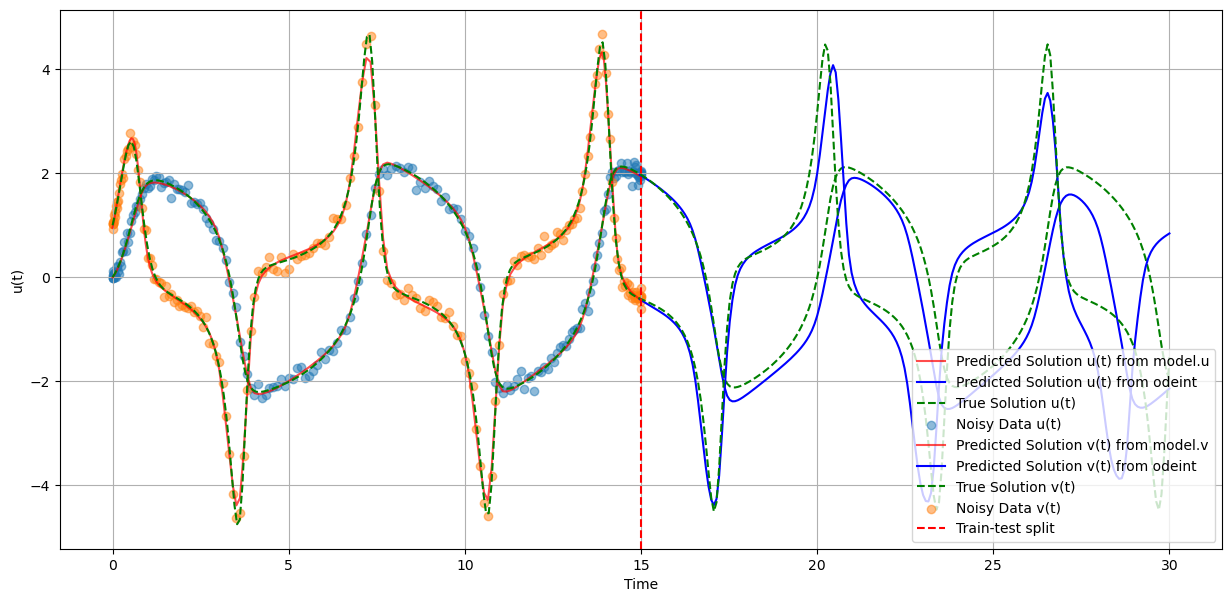

In [140]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t_test[N-1:], y_pred_test.T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t_test, y_test.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t_test[N-1:], y_pred_test.T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t_test, y_test.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=15, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [141]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "damped_oscillation", {"damping_factor": 0.1, "omega_squared": 1}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

In [143]:
layer_widths = [3, 10, 2]

start_timer_build = time.time()
ode_model = ODEOptimizationModel(y_noisy, t, D, layer_widths, extra_input=t, max_iter = 1000, act_func = "tanh", y_init = estimated_solution, w_init_method = 'xavier') # , y_init = estimated_solution
ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()

u_model, v_model = ode_model.extract_solution()

def system_dynamics(y, t):
    input = jnp.array([y[0], y[1], t])
    du_dt, dv_dt = ode_model.predict(input)
    return jnp.array([du_dt, dv_dt])

initial_conditions = jnp.array([0.0, 1.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y))
y_pred_test = odeint(system_dynamics, initial_conditions, t_test)   
mae_test = jnp.mean(jnp.abs(y_pred_test[N:] - y_test[N:]))

print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")
print(result)

Ipopt 3.14.16: max_iter=1000
print_level=5
tol=1e-08
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:   100296
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    24681

Total number of variables............................:      462
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      462
                     variables with only upper bounds:        0
Total number of

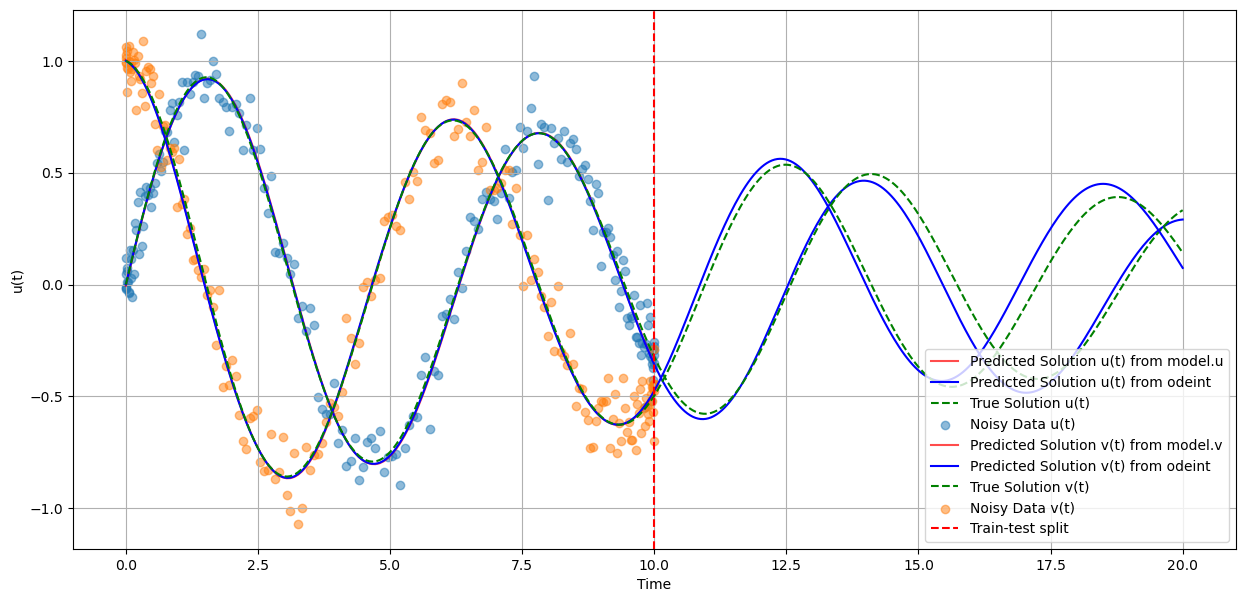

In [144]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t, u_model, 'r', alpha = 0.7, label='Predicted Solution u(t) from model.u')
plt.plot(t_test, y_pred_test.T[0], 'b', label='Predicted Solution u(t) from odeint')
plt.plot(t_test, y_test.T[0], 'g--', label='True Solution u(t)')
plt.scatter(t, y_noisy.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.plot(t, v_model, 'r', alpha = 0.7, label='Predicted Solution v(t) from model.v')
plt.plot(t_test, y_pred_test.T[1], 'b', label='Predicted Solution v(t) from odeint')
plt.plot(t_test, y_test.T[1], 'g--', label='True Solution v(t)')
plt.scatter(t, y_noisy.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()